# Sc vs Ap polarity modelling

Goryachev paper suggests:
- PAK-GEF-BEM can be modelled as one component 
- PAK-GEF-BEM is in fast cyt:mem equilibrium, diffusion and exchange rates are negledgable (probably not...)
- Activation of Cdc24 is carried out by PAK-GEF-BEM-Cdc42T not PAK-GEF-BEM (so much slower its negledgable)
- Cdc42D diffusion happens only by exchange, not membrane diffusion

Dm = 0.0025
Dc = 10
n = 0.01


I want to be able to tweak:
- Domain size, cytosolic concentrations
- Cdc42 exchange rate (rdi1-del)

Wu 2015: Role of competition...

In [34]:
using DifferentialEquations
using Sundials              # required for fastest solver
using Plots
using Statistics            # required for random
using LinearAlgebra         # required for Tridiagonal
using Random
#using ModelingToolkit
#using Colors
#using Images


Time scale of cytosolic diffusion (~6um^2/s) (FRAP becomes homogenous in a few seconds)
    Is it much faster than reaction for exchange at membrane? (FRAP recovery takes 30s for Cdc42, longer for others.)
        Is exchange at membrane much faster than membrane-associated diffusion? (Try simulation. How long for homogeneity with diffusion alone)

In [27]:
# Generate constants
N = 100             # Domain resolution. Number of pixels.
Ax0 = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1])) # Stencil for diffusion.
Ax0[1,end] = 1.0    # Modifications for periodic boundaries.
Ax0[end,1] = 1.0    # Modifications for periodic boundaries.

diameter = 10
SAtoV = 6/diameter    # SA/V: 6/d where d=10. 0.6 micron^-1
dx = diameter/N     # Spatial step size: 0.1 microns per pixel. 10um diameter.
Ax = Ax0/dx^2       # Scale diffusion stencil. dt/dx^2. dt is multiplied within loop.

# Dummy parameters used only locally in fxn but passed to specify scope, or something..
Ayt = zeros(N)
Ayd = zeros(N)
tAx = zeros(N)
dAx = zeros(N)
Dt = zeros(N)
Dd = zeros(N)
R1 = zeros(N)
E = 0

0

In [25]:
# Initial conditions
mem_species = 4
r0 = zeros(100,mem_species)
r0[:,1] .= randexp.()   # Cdc42T
r0[:,2] .= 1            # Cdc42D
r0[:,3] .= 0.02         # BemGEF
r0[:,4] .= 0.01         # BemGEF42

Cdc42c = 1
GEFc = 0.02

100×100 Matrix{Float64}:
 -200.0   100.0     0.0     0.0     0.0  …     0.0     0.0     0.0   100.0
  100.0  -200.0   100.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0   100.0  -200.0   100.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0   100.0  -200.0   100.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0   100.0  -200.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0   100.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    ⋮                                    ⋱                          
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.

In [ ]:
# Check total GEF and total Cdc42


In [362]:
function yeast_fast!(dr,r,p,t)
    Ka, Ki, D1, tAx, Dt, R1 = p

    rhoT = @view r[:,1]
    rhoD = @view r[:,2]
    rhoD .= mean(rhoD)
    E = 0.017/(1+sum((rhoT.^2 *(100/3) .+1)))
    dgtp = @view dr[:,1]
    dgdp = @view dr[:,2]
    mul!(tAx,Ax,rhoT)
    @. Dt = D1*(tAx)
    @. R1 = Ka*E*rhoT^2*rhoD - Ki*rhoT
    @. dgtp = Dt + R1
    @. dgdp = - R1
    end

yeast_fast! (generic function with 1 method)

In [357]:
Ka = 50
Ki = 0.1
D1 = 0.005

p = (Ka, Ki, D1,tAx,Dt,R1)
# p = (10,0.1,0.005,tAx,Dt,R1)
# params for alt pos fb equation
yf = ODEProblem(yeast_fast!,r0,(0.0,600),p)
sol_yf = solve(yf,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 601-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 592.0
 593.0
 594.0
 595.0
 596.0
 597.0
 598.0
 599.0
 600.0
u: 601-element Vector{Matrix{Float64}}:
 [0.36228304049550114 0.9020905355912675; 0.2767211225009749 0.9020905355912675; … ; 0.34476133865698877 0.9020905355912675; 0.325760756526021 0.9020905355912675]
 [0.3280208777714189 0.9357850044827012; 0.2510016601709687 0.9279007404750009; … ; 0.3119709806039988 0.9341534001250671; 0.29564831469188324 0.9324574735292658]
 [0.29668400174644133 0.9666072155095188; 0.2274348637185762 0.951551162720481; … ; 0.2820008412084844 0.9634683416818903; 0.2680367727851225 0.9602952407726931]
 [0.2682161153040608 0.9946118286426008; 0.20598522114417672 0.9730773523231013; … ; 0.25479352912987313 0.9900899457682947; 0.24288793149678692 0.9856435042747166]
 [0.24225765898398394 1.0201512560567072; 0.186394760790541 0.9927380451668018; … ; 0.22

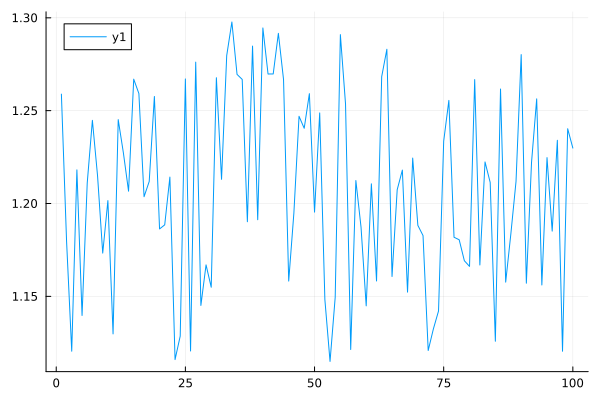

In [358]:
Plots.plot(sol_yf.u[600][:,end])

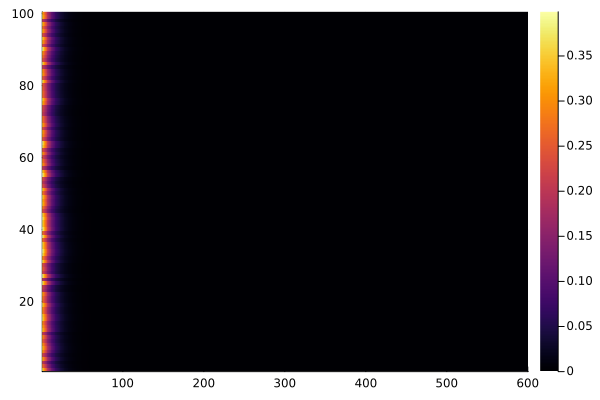

In [359]:
X = zeros(100,600)
for i in 1:600
    tmp = sol_yf[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X)

In [323]:
sol_yf

retcode: Success
Interpolation: 1st order linear
t: 601-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 592.0
 593.0
 594.0
 595.0
 596.0
 597.0
 598.0
 599.0
 600.0
u: 601-element Vector{Matrix{Float64}}:
 [0.23077346155174966 1.3827245200359617; 0.2449505899802878 1.3827245200359617; … ; 0.2995260481400277 1.3827245200359617; 0.3239130240879531 1.3827245200359617]
 [0.26046423894095877 1.3829353862031308; 0.2597327148651442 1.3829391305424463; … ; 0.276665680987273 1.3829610314721204; 0.28821160934696005 1.3829715304174173]
 [0.26685441865199805 1.383156861350003; 0.26299056252165004 1.3831586916382037; … ; 0.26601546604706733 1.383186599489722; 0.27497860558945114 1.383203664422518]
 [0.2668786567335204 1.3833799094391328; 0.2637751851688761 1.3833792739799031; … ; 0.2605796941415839 1.3834068236609438; 0.2684860116386136 1.383429490770723]
 [0.2655129489624012 1.3836022420799496; 0.2640072427971734 1.3836000306989553; … ; 0.25757